In [1]:
from POSEIDON.core import create_planet, create_star, define_model, \
    make_atmosphere, read_opacities, wl_grid_constant_R, compute_spectrum

from POSEIDON.constants import R_E, M_E, R_Sun
import astropy.units as u
import astropy.constants as c
import numpy as np

model_name = 'training_set'

bulk_species = ['N2']
param_species = ['O2', 'CO2', 'CH4', 'H2O', 'O3', 'N2O']

model = define_model(model_name, bulk_species, param_species,
                    PT_profile = 'isotherm', cloud_model = 'cloud-free',
                    radius_unit = 'R_E')

#***** Wavelength grid *****#

wl_min = 0.3      # Minimum wavelength (um)
wl_max = 25.      # Maximum wavelength (um)
R = 200         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 20     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step),
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine, opacity_database='Temperate')

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
CO2-CH4 done
N2-N2 done
N2-H2O done
O2-O2 done
O2-CO2 done
O2-N2 done
O2 done
CO2 done
CH4 done
H2O done
O3 done
N2O done
Opacity pre-interpolation complete.


Opacity uses about 17 GB mem

In [2]:
# Import the sampled parameters
# data_formats = ['%d'] + ['%.3f'] * 12
sampled_parameters = np.loadtxt('../data/sampled_parameters.csv', delimiter=',', skiprows=1)#, dtype=data_formats)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 1.0      # 1 bar
N_layers = 100    # 100 layers

P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Add the surface pressure
P_surf = 1.0      # Effectively acts as a cloud deck opaque at all wavelengths

def generate_spectra(indx):

    params = sampled_parameters[indx]
    #***** Unpack parameters *****#
    index = params[0]
    T_eff = params[1] # Effective temperature (K)
    R_s = params[2] * R_Sun # Stellar radius (R_Sun)
    log_g = params[3] # Stellar surface gravity (log10(g/cm/s^2))
    met = params[4] # Stellar metallicity (log10(Z/Z_sun))
    R_p = params[5] * R_E
    M_p = params[6] * M_E

    T_eq = params[7] # Equilibrium temperature (K)
    # CH4, H2O, CO2, O2, O3, N20
    log_X_params = np.array(params[8:]) # Log10(mixing ratio) of the parameters

    #***** Update Model *****#
    model_name = 'model_' + str(indx)
    model['model_name'] = model_name

    #***** Create star *****#
    star = create_star(R_s, T_eff, log_g, met)

    #***** Create planet *****#
    planet_name = 'planet_' + str(indx)
    planet = create_planet(planet_name, R_p, mass = M_p, T_eq = T_eq)

    #***** Define atmosphere *****#

    # Specify the reference pressure and radius
    P_ref = P_surf    # We'll set the reference pressure at the surface
    R_p_ref = R_p     # Radius at reference pressure

    PT_params = np.array([T_eq])

    atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref,
                                PT_params, log_X_params)

    spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')
    return spectrum, planet, star, atmosphere

spectrum, planet, star, atmosphere = generate_spectra(20)

In [7]:
import time
start = time.time()
for i in range(10000):
    spectrum, planet, star, atmosphere = generate_spectra(i)

end = time.time()
print(f'Time taken for {i+1} spectra: ', end - start)

Time taken for 10000 spectra:  53.2803590297699


For 3,000,000 spectra, would take >120 hours to model and occupy ~3.5 Tb of space (~1.1 Mb/spectrum at R=10,000)

In [ ]:
import multiprocessing as mp

def init_pool(opacities):
    """
    Initialize the pool for parallel processing.
    """
    
    global opac
    opac = opacities

start = time.time()

pool = mp.Pool(2, initializer=init_pool, initargs=(opac,))
# Generate spectra in parallel
spectra = pool.map(generate_spectra, range(10000))
pool.close()
pool.join()
end = time.time()
print('Time taken for 100 spectra in parallel: ', end - start)

Process SpawnPoolWorker-3:
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/shockblack/opt/anaconda3/envs/POSEIDON/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/shockblack/opt/anaconda3/envs/POSEIDON/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shockblack/opt/anaconda3/envs/POSEIDON/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/shockblack/opt/anaconda3/envs/POSEIDON/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'generate_spectra' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/Users/shockblack/opt/anaconda3/envs/POSEIDON/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/shockblack/opt/anaconda3/envs/POSEIDON/lib/python3.10

KeyboardInterrupt: 

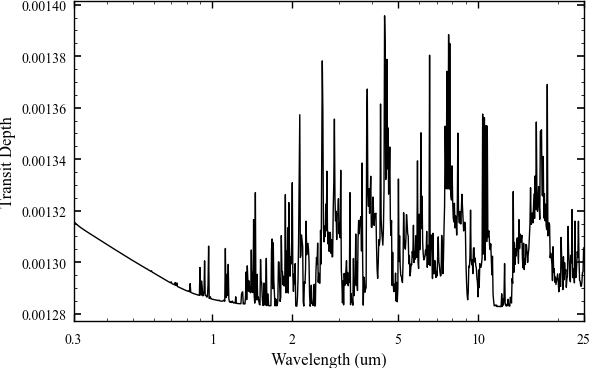

In [3]:
import matplotlib.pyplot as plt
plt.style.use('az-paper-twocol')
plt.plot(wl, spectrum, lw=1)
plt.xscale('log')
plt.xlim(0.3, 25)
plt.xticks([0.3, 1, 2, 5, 10, 25], ['0.3', '1', '2', '5', '10', '25'])
plt.xlabel('Wavelength (um)')
plt.ylabel('Transit Depth')
plt.show()